In [14]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio

import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [15]:
def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


In [16]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [17]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898639,1079178800,AAPL,2,0.0,5.903856,5.896148,100.0,-66.666667,100.0,5.898639,5.898639
3483,2008-01-02,46.599998,47.040001,46.259998,33.761406,7934400,AMGN,2,0.0,5.903856,5.896148,100.0,-66.666667,100.0,33.761406,33.761406
6966,2008-01-02,52.090000,52.320000,50.790001,39.588005,8053700,AXP,2,0.0,5.903856,5.896148,100.0,-66.666667,100.0,39.588005,39.588005
10449,2008-01-02,87.570000,87.839996,86.000000,63.481621,4303000,BA,2,0.0,5.903856,5.896148,100.0,-66.666667,100.0,63.481621,63.481621
13932,2008-01-02,72.559998,72.669998,70.050003,45.605473,6337800,CAT,2,0.0,5.903856,5.896148,100.0,-66.666667,100.0,45.605473,45.605473


In [18]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424915,156.635672,144.752564,55.691947,130.838046,19.622993,149.630910,150.155366
87074,2021-10-29,454.410004,461.390015,453.059998,447.971100,2497800,UNH,4,12.812447,459.914526,366.732065,67.009711,145.348183,52.064871,406.440823,405.562358
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170569,48.086325,45.189778,46.684996,-39.966418,12.569826,46.875141,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,41.523602,4999000,WBA,4,-0.169815,44.202653,40.524218,45.913446,-97.394948,0.268701,42.391107,42.889372
97523,2021-10-29,147.910004,150.100006,147.559998,144.852402,7340900,WMT,4,1.795642,147.887265,129.205263,59.710622,130.750132,35.423702,138.057026,140.642313


In [19]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093651,2.454291,42.254764,-80.462589,16.129793,2.749560,2.861671,"[[0.0013489686083911383, 0.0004284124186726731...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839520,6287200,AMGN,2,0.156757,42.707025,40.853195,51.060616,51.523377,10.432018,41.058031,40.603775,"[[0.0013489686083911383, 0.0004284124186726731...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580752,9625600,AXP,2,-0.935582,18.646868,12.660477,42.554853,-75.437650,25.776759,15.744065,17.616375,"[[0.0013489686083911383, 0.0004284124186726731...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2,-0.279800,32.174381,28.867832,47.440235,156.994811,5.366299,30.327212,32.389914,"[[0.0013489686083911383, 0.0004284124186726731...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608644,6277400,CAT,2,0.655610,30.348092,25.455646,51.205289,98.374043,26.331746,26.689551,26.423592,"[[0.0013489686083911383, 0.0004284124186726731...",tic AAPL AMGN AXP ...


In [20]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
trade = data_split(df, '2020-07-01', '2021-10-31')
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747391,746015200,AAPL,4,-0.070153,3.080129,2.452222,45.440197,-32.212835,2.140064,2.750408,2.862473,"[[0.0013661503841569359, 0.0004339379068753712...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737881,6547900,AMGN,4,0.232162,42.852617,40.817726,52.756840,92.827790,0.814217,41.122028,40.691921,"[[0.0013661503841569359, 0.0004339379068753712...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193848,10955700,AXP,4,-0.832049,18.463254,12.644441,43.957551,-42.853088,16.335101,15.742755,17.499520,"[[0.0013661503841569359, 0.0004339379068753712...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4,-0.002009,32.948624,28.452126,50.822034,272.812896,20.494464,30.469477,32.344129,"[[0.0013661503841569359, 0.0004339379068753712...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093403,7117200,CAT,4,0.833183,30.850192,25.434761,53.661258,129.524708,34.637448,26.926403,26.424173,"[[0.0013661503841569359, 0.0004339379068753712...",tic AAPL AMGN AXP ...


In [21]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym_random = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


In [22]:
import random
def random_agent(env: StockPortfolioEnv):
    env.reset()
    terminal = False
    while not terminal:
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

In [23]:
env_rand_post_training = random_agent(e_train_gym_random)

begin_total_asset:1000000
end_total_asset:1903603.8216318213
Sharpe:  0.3453358943834626


In [24]:
from agents.single_stock_tabular import sarsa_single_stock

In [25]:
end_of_training_assets = []
end_of_trading_assets = []
episodes_for_training = list(range(1,51, 5))
for e in episodes_for_training:
    # todo, Need to test performance on 
    e_train_gym_single_stock_sarsa = StockPortfolioEnv(df = train, **env_kwargs)
    _, _, Q = sarsa_single_stock(e_train_gym_single_stock_sarsa, num_episodes=e, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0)
    end_of_training_assets.append(e_train_gym_single_stock_sarsa.asset_memory)
    e_train_gym_single_stock_sarsa.reset()
    
    e_trade_gym_single_stock_sarsa = StockPortfolioEnv(df = trade, **env_kwargs)
    sarsa_single_stock(e_trade_gym_single_stock_sarsa, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=Q)
    end_of_trading_assets.append(e_trade_gym_single_stock_sarsa.asset_memory)
    e_trade_gym_single_stock_sarsa.reset()
    
    

begin_total_asset:1000000
end_total_asset:3983436.5497523043
Sharpe:  0.7578982521240575


begin_total_asset:1000000
end_total_asset:1072645.6323615732
Sharpe:  0.6723268875793709


Episode:  17%|█▋        | 1/6 [00:10<00:51, 10.20s/it]

begin_total_asset:1000000
end_total_asset:4992563.324867899
Sharpe:  0.9518630161593532


Episode:  33%|███▎      | 2/6 [00:20<00:40, 10.22s/it]

begin_total_asset:1000000
end_total_asset:5680640.629301916
Sharpe:  0.9519771647875312


Episode:  50%|█████     | 3/6 [00:30<00:30, 10.27s/it]

begin_total_asset:1000000
end_total_asset:4027550.454506678
Sharpe:  0.7511741457395875


Episode:  67%|██████▋   | 4/6 [00:41<00:20, 10.26s/it]

begin_total_asset:1000000
end_total_asset:5461968.850975315
Sharpe:  0.8959503805963768


Episode:  83%|████████▎ | 5/6 [00:51<00:10, 10.34s/it]

begin_total_asset:1000000
end_total_asset:5831093.583707441
Sharpe:  1.0887731554980284


begin_total_asset:1000000
end_total_asset:4138262.5401917174
Sharpe:  0.771925798445259


begin_total_asset:1000000
end_total_asset:1002302.6980267129
Sharpe:  0.06329673071398588


Episode:   9%|▉         | 1/11 [00:10<01:42, 10.29s/it]

begin_total_asset:1000000
end_total_asset:6188554.197258172
Sharpe:  0.9645444280257611


Episode:  18%|█▊        | 2/11 [00:20<01:33, 10.34s/it]

begin_total_asset:1000000
end_total_asset:3829091.043156345
Sharpe:  0.7415078858622527


Episode:  27%|██▋       | 3/11 [00:31<01:22, 10.35s/it]

begin_total_asset:1000000
end_total_asset:4361489.340707085
Sharpe:  0.839002326302832


Episode:  36%|███▋      | 4/11 [00:41<01:12, 10.36s/it]

begin_total_asset:1000000
end_total_asset:3234680.2069478403
Sharpe:  0.7025795055805008


Episode:  45%|████▌     | 5/11 [00:51<01:02, 10.34s/it]

begin_total_asset:1000000
end_total_asset:9890278.006202111
Sharpe:  1.0327225251356016


Episode:  55%|█████▍    | 6/11 [01:02<00:51, 10.34s/it]

begin_total_asset:1000000
end_total_asset:18370846.739458982
Sharpe:  1.6185716009882491


Episode:  64%|██████▎   | 7/11 [01:12<00:41, 10.34s/it]

begin_total_asset:1000000
end_total_asset:3585855.9358746735
Sharpe:  0.8830489685866224


Episode:  73%|███████▎  | 8/11 [01:22<00:30, 10.30s/it]

begin_total_asset:1000000
end_total_asset:7305018.529438481
Sharpe:  1.012893322816553


Episode:  82%|████████▏ | 9/11 [01:32<00:20, 10.29s/it]

begin_total_asset:1000000
end_total_asset:4296837.107851951
Sharpe:  0.8311382469432901


Episode:  91%|█████████ | 10/11 [01:43<00:10, 10.35s/it]

begin_total_asset:1000000
end_total_asset:3108428.6148855654
Sharpe:  0.7667244653542309


begin_total_asset:1000000
end_total_asset:3307322.565391372
Sharpe:  0.6530653064759493


begin_total_asset:1000000
end_total_asset:1097429.853191985
Sharpe:  0.932395852239026


Episode:   6%|▋         | 1/16 [00:10<02:35, 10.36s/it]

begin_total_asset:1000000
end_total_asset:10309686.402057972
Sharpe:  0.9670585295554928


Episode:  12%|█▎        | 2/16 [00:20<02:25, 10.36s/it]

begin_total_asset:1000000
end_total_asset:3458283.7643863717
Sharpe:  0.8286734821539617


Episode:  19%|█▉        | 3/16 [00:31<02:14, 10.36s/it]

begin_total_asset:1000000
end_total_asset:3702642.7805458624
Sharpe:  0.7560007386583019


Episode:  25%|██▌       | 4/16 [00:41<02:06, 10.55s/it]

begin_total_asset:1000000
end_total_asset:4546147.367218773
Sharpe:  0.8013038160859428


Episode:  31%|███▏      | 5/16 [00:52<01:54, 10.39s/it]

begin_total_asset:1000000
end_total_asset:3045520.893821584
Sharpe:  0.658424754368682


Episode:  38%|███▊      | 6/16 [01:02<01:43, 10.34s/it]

begin_total_asset:1000000
end_total_asset:2943342.174713206
Sharpe:  0.7842874323696021


Episode:  44%|████▍     | 7/16 [01:12<01:32, 10.28s/it]

begin_total_asset:1000000
end_total_asset:9947748.571348164
Sharpe:  1.1708326062597887


Episode:  50%|█████     | 8/16 [01:22<01:21, 10.20s/it]

begin_total_asset:1000000
end_total_asset:8946551.624850066
Sharpe:  1.1215659143230075


Episode:  56%|█████▋    | 9/16 [01:32<01:11, 10.15s/it]

begin_total_asset:1000000
end_total_asset:7343064.917909234
Sharpe:  1.1265142970181057


Episode:  62%|██████▎   | 10/16 [01:42<01:01, 10.20s/it]

begin_total_asset:1000000
end_total_asset:2734242.417289438
Sharpe:  0.6370170571052535


Episode:  69%|██████▉   | 11/16 [01:52<00:50, 10.17s/it]

begin_total_asset:1000000
end_total_asset:7812153.700255234
Sharpe:  1.1539313940065572


Episode:  75%|███████▌  | 12/16 [02:02<00:40, 10.14s/it]

begin_total_asset:1000000
end_total_asset:5705809.971068052
Sharpe:  0.9552991399838614


Episode:  81%|████████▏ | 13/16 [02:13<00:30, 10.15s/it]

begin_total_asset:1000000
end_total_asset:6453088.420590177
Sharpe:  0.9810123407387743


Episode:  88%|████████▊ | 14/16 [02:23<00:20, 10.24s/it]

begin_total_asset:1000000
end_total_asset:5736110.237539122
Sharpe:  0.8919310012146981


Episode:  94%|█████████▍| 15/16 [02:33<00:10, 10.25s/it]

begin_total_asset:1000000
end_total_asset:5221244.208030689
Sharpe:  0.8071810001868575


begin_total_asset:1000000
end_total_asset:6635992.804571148
Sharpe:  1.0547889456894888


begin_total_asset:1000000
end_total_asset:1394896.8244325593
Sharpe:  1.0659595147666396


Episode:   5%|▍         | 1/21 [00:10<03:21, 10.07s/it]

begin_total_asset:1000000
end_total_asset:14519698.299877187
Sharpe:  1.2372402971258762


Episode:  10%|▉         | 2/21 [00:20<03:10, 10.04s/it]

begin_total_asset:1000000
end_total_asset:6623322.984652835
Sharpe:  1.2061968490403818


Episode:  14%|█▍        | 3/21 [00:30<03:01, 10.09s/it]

begin_total_asset:1000000
end_total_asset:9771622.760871282
Sharpe:  1.2149417682141237


Episode:  19%|█▉        | 4/21 [00:40<02:51, 10.07s/it]

begin_total_asset:1000000
end_total_asset:4964378.227055693
Sharpe:  0.8415657384033026


Episode:  24%|██▍       | 5/21 [00:50<02:41, 10.07s/it]

begin_total_asset:1000000
end_total_asset:6345097.657930698
Sharpe:  0.9109574372407351


Episode:  29%|██▊       | 6/21 [01:00<02:32, 10.14s/it]

begin_total_asset:1000000
end_total_asset:9708114.041495984
Sharpe:  1.1395455648313721


Episode:  33%|███▎      | 7/21 [01:10<02:21, 10.12s/it]

begin_total_asset:1000000
end_total_asset:2041333.4891428598
Sharpe:  0.6268845617501239


Episode:  38%|███▊      | 8/21 [01:20<02:11, 10.13s/it]

begin_total_asset:1000000
end_total_asset:3109852.7748013185
Sharpe:  0.6416328799679971


Episode:  43%|████▎     | 9/21 [01:31<02:02, 10.17s/it]

begin_total_asset:1000000
end_total_asset:3800555.206788467
Sharpe:  0.8707673791770112


Episode:  48%|████▊     | 10/21 [01:41<01:51, 10.17s/it]

begin_total_asset:1000000
end_total_asset:7696345.111986827
Sharpe:  1.0468930412993043


Episode:  52%|█████▏    | 11/21 [01:51<01:41, 10.18s/it]

begin_total_asset:1000000
end_total_asset:5394962.8541353475
Sharpe:  0.9452440841462004


Episode:  57%|█████▋    | 12/21 [02:01<01:31, 10.17s/it]

begin_total_asset:1000000
end_total_asset:2932231.1223399965
Sharpe:  0.7384451293914079


Episode:  62%|██████▏   | 13/21 [02:11<01:21, 10.17s/it]

begin_total_asset:1000000
end_total_asset:3616225.0775240962
Sharpe:  0.818158526584815


Episode:  67%|██████▋   | 14/21 [02:22<01:11, 10.18s/it]

begin_total_asset:1000000
end_total_asset:19029120.185199283
Sharpe:  1.3546188603972642


Episode:  71%|███████▏  | 15/21 [02:32<01:01, 10.17s/it]

begin_total_asset:1000000
end_total_asset:3263278.1784602357
Sharpe:  0.7346610162088616


Episode:  76%|███████▌  | 16/21 [02:42<00:50, 10.15s/it]

begin_total_asset:1000000
end_total_asset:8860443.776971808
Sharpe:  0.9268488465833187


Episode:  81%|████████  | 17/21 [02:52<00:40, 10.14s/it]

begin_total_asset:1000000
end_total_asset:4233639.921016092
Sharpe:  0.9272970519932113


Episode:  86%|████████▌ | 18/21 [03:02<00:30, 10.17s/it]

begin_total_asset:1000000
end_total_asset:2296829.381389852
Sharpe:  0.5650077879175236


Episode:  90%|█████████ | 19/21 [03:12<00:20, 10.17s/it]

begin_total_asset:1000000
end_total_asset:4089687.8701044708
Sharpe:  0.7816949784849957


Episode:  95%|█████████▌| 20/21 [03:23<00:10, 10.24s/it]

begin_total_asset:1000000
end_total_asset:5683995.550079882
Sharpe:  1.0016770583117909


begin_total_asset:1000000
end_total_asset:19609803.921114057
Sharpe:  1.4427715184787153


begin_total_asset:1000000
end_total_asset:1443332.197840966
Sharpe:  1.3150616891060698


Episode:   4%|▍         | 1/26 [00:10<04:13, 10.12s/it]

begin_total_asset:1000000
end_total_asset:5044535.282299209
Sharpe:  0.7897551141217894


Episode:   8%|▊         | 2/26 [00:20<04:03, 10.15s/it]

begin_total_asset:1000000
end_total_asset:4445146.96326768
Sharpe:  0.9087379502781766


Episode:  12%|█▏        | 3/26 [00:30<03:53, 10.16s/it]

begin_total_asset:1000000
end_total_asset:6053638.768626464
Sharpe:  0.860423014871599


Episode:  15%|█▌        | 4/26 [00:40<03:43, 10.15s/it]

begin_total_asset:1000000
end_total_asset:3879177.8298185645
Sharpe:  0.7902091887130028


Episode:  19%|█▉        | 5/26 [00:50<03:33, 10.17s/it]

begin_total_asset:1000000
end_total_asset:3694575.0473191068
Sharpe:  0.7407961273798265


Episode:  23%|██▎       | 6/26 [01:00<03:23, 10.16s/it]

begin_total_asset:1000000
end_total_asset:8207211.350287887
Sharpe:  1.1462032177969093


Episode:  27%|██▋       | 7/26 [01:11<03:13, 10.18s/it]

begin_total_asset:1000000
end_total_asset:8285611.872167402
Sharpe:  1.1638871539719402


Episode:  31%|███       | 8/26 [01:21<03:06, 10.36s/it]

begin_total_asset:1000000
end_total_asset:5462870.121551908
Sharpe:  1.0015296171516057


Episode:  35%|███▍      | 9/26 [01:33<03:00, 10.63s/it]

begin_total_asset:1000000
end_total_asset:7888695.260974268
Sharpe:  1.2555599393139913


Episode:  38%|███▊      | 10/26 [01:43<02:48, 10.50s/it]

begin_total_asset:1000000
end_total_asset:4811212.381486267
Sharpe:  0.7871819199703464


Episode:  42%|████▏     | 11/26 [01:53<02:36, 10.42s/it]

begin_total_asset:1000000
end_total_asset:1773091.8336264521
Sharpe:  0.4155757891772986


Episode:  46%|████▌     | 12/26 [02:03<02:25, 10.37s/it]

begin_total_asset:1000000
end_total_asset:2289585.3094412126
Sharpe:  0.6737232765712533


Episode:  50%|█████     | 13/26 [02:14<02:14, 10.34s/it]

begin_total_asset:1000000
end_total_asset:8513513.950592665
Sharpe:  1.0891423922638015


Episode:  54%|█████▍    | 14/26 [02:24<02:04, 10.40s/it]

begin_total_asset:1000000
end_total_asset:2301899.576911731
Sharpe:  0.7204602935061852


Episode:  58%|█████▊    | 15/26 [02:34<01:53, 10.36s/it]

begin_total_asset:1000000
end_total_asset:7726171.733810748
Sharpe:  1.0286396453634274


Episode:  62%|██████▏   | 16/26 [02:45<01:43, 10.35s/it]

begin_total_asset:1000000
end_total_asset:8752733.071070429
Sharpe:  1.1844418233647176


Episode:  65%|██████▌   | 17/26 [02:55<01:33, 10.33s/it]

begin_total_asset:1000000
end_total_asset:10156237.592437577
Sharpe:  1.1101611310386685


Episode:  69%|██████▉   | 18/26 [03:05<01:22, 10.31s/it]

begin_total_asset:1000000
end_total_asset:6561131.492054955
Sharpe:  1.1313773689376028


Episode:  73%|███████▎  | 19/26 [03:16<01:12, 10.29s/it]

begin_total_asset:1000000
end_total_asset:3155611.060234678
Sharpe:  0.8781592508578999


Episode:  77%|███████▋  | 20/26 [03:26<01:01, 10.29s/it]

begin_total_asset:1000000
end_total_asset:6191465.914172547
Sharpe:  0.9650229952041369


Episode:  81%|████████  | 21/26 [03:36<00:51, 10.28s/it]

begin_total_asset:1000000
end_total_asset:4026975.267390609
Sharpe:  0.9902497688047515


Episode:  85%|████████▍ | 22/26 [03:46<00:41, 10.27s/it]

begin_total_asset:1000000
end_total_asset:3407521.4204449216
Sharpe:  0.7744182478903479


Episode:  88%|████████▊ | 23/26 [03:57<00:30, 10.25s/it]

begin_total_asset:1000000
end_total_asset:5684456.621109135
Sharpe:  0.9474540256642688


Episode:  92%|█████████▏| 24/26 [04:07<00:20, 10.25s/it]

begin_total_asset:1000000
end_total_asset:4889511.448592716
Sharpe:  0.9168932919807514


Episode:  96%|█████████▌| 25/26 [04:18<00:10, 10.41s/it]

begin_total_asset:1000000
end_total_asset:4343046.026745543
Sharpe:  0.8955771732724676


begin_total_asset:1000000
end_total_asset:4830177.6513220975
Sharpe:  0.8833515763375309


begin_total_asset:1000000
end_total_asset:1177069.9615796066
Sharpe:  1.357609383592835


Episode:   3%|▎         | 1/31 [00:10<05:11, 10.37s/it]

begin_total_asset:1000000
end_total_asset:11085888.952148747
Sharpe:  0.9997391545237165


Episode:   6%|▋         | 2/31 [00:20<05:00, 10.37s/it]

begin_total_asset:1000000
end_total_asset:13419317.1282556
Sharpe:  1.2299670787281685


Episode:  10%|▉         | 3/31 [00:31<04:49, 10.33s/it]

begin_total_asset:1000000
end_total_asset:4705766.236079253
Sharpe:  0.832374704084809


Episode:  13%|█▎        | 4/31 [00:41<04:41, 10.41s/it]

begin_total_asset:1000000
end_total_asset:3502787.334573639
Sharpe:  0.886977767642023


Episode:  16%|█▌        | 5/31 [00:51<04:30, 10.41s/it]

begin_total_asset:1000000
end_total_asset:14237815.577514281
Sharpe:  1.3011523604652586


Episode:  19%|█▉        | 6/31 [01:02<04:18, 10.36s/it]

begin_total_asset:1000000
end_total_asset:4692056.271643825
Sharpe:  0.794645462438625


Episode:  23%|██▎       | 7/31 [01:12<04:07, 10.31s/it]

begin_total_asset:1000000
end_total_asset:1961934.740323043
Sharpe:  0.48575108378579335


Episode:  26%|██▌       | 8/31 [01:22<03:56, 10.28s/it]

begin_total_asset:1000000
end_total_asset:2508706.874566195
Sharpe:  0.6366724904025727


Episode:  29%|██▉       | 9/31 [01:32<03:46, 10.29s/it]

begin_total_asset:1000000
end_total_asset:6066456.802210269
Sharpe:  1.2394360895465504


Episode:  32%|███▏      | 10/31 [01:43<03:36, 10.30s/it]

begin_total_asset:1000000
end_total_asset:4180050.575140521
Sharpe:  0.8779636792054528


Episode:  35%|███▌      | 11/31 [01:53<03:25, 10.29s/it]

begin_total_asset:1000000
end_total_asset:5616148.463579409
Sharpe:  0.8165592676492386


Episode:  39%|███▊      | 12/31 [02:03<03:16, 10.32s/it]

begin_total_asset:1000000
end_total_asset:20286157.590121023
Sharpe:  1.4335263145390291


Episode:  42%|████▏     | 13/31 [02:14<03:06, 10.37s/it]

begin_total_asset:1000000
end_total_asset:4331749.316440522
Sharpe:  0.8519001465835537


Episode:  45%|████▌     | 14/31 [02:24<02:57, 10.42s/it]

begin_total_asset:1000000
end_total_asset:6037044.2457494475
Sharpe:  1.0808054613186395


Episode:  48%|████▊     | 15/31 [02:35<02:46, 10.41s/it]

begin_total_asset:1000000
end_total_asset:5675113.542044103
Sharpe:  0.8913846370696549


Episode:  52%|█████▏    | 16/31 [02:45<02:35, 10.36s/it]

begin_total_asset:1000000
end_total_asset:9688519.196988204
Sharpe:  1.1338988144907642


Episode:  55%|█████▍    | 17/31 [02:55<02:24, 10.33s/it]

begin_total_asset:1000000
end_total_asset:4850639.315040985
Sharpe:  0.9351402456938938


Episode:  58%|█████▊    | 18/31 [03:06<02:14, 10.33s/it]

begin_total_asset:1000000
end_total_asset:4451163.77838456
Sharpe:  0.7937810374968378


Episode:  61%|██████▏   | 19/31 [03:16<02:03, 10.31s/it]

begin_total_asset:1000000
end_total_asset:3640778.2462015627
Sharpe:  0.7557933920044443


Episode:  65%|██████▍   | 20/31 [03:26<01:53, 10.30s/it]

begin_total_asset:1000000
end_total_asset:13860057.560011046
Sharpe:  1.149214757483896


Episode:  68%|██████▊   | 21/31 [03:37<01:43, 10.30s/it]

begin_total_asset:1000000
end_total_asset:13650459.507441664
Sharpe:  1.552748628126496


Episode:  71%|███████   | 22/31 [03:47<01:33, 10.39s/it]

begin_total_asset:1000000
end_total_asset:13570298.353726685
Sharpe:  1.1114984289251504


Episode:  74%|███████▍  | 23/31 [03:57<01:22, 10.36s/it]

begin_total_asset:1000000
end_total_asset:3712892.8420305164
Sharpe:  0.9695922091815955


Episode:  77%|███████▋  | 24/31 [04:08<01:12, 10.35s/it]

begin_total_asset:1000000
end_total_asset:3670376.4985460727
Sharpe:  0.7319839731586126


Episode:  81%|████████  | 25/31 [04:18<01:01, 10.30s/it]

begin_total_asset:1000000
end_total_asset:5041470.180443958
Sharpe:  0.8182350635290138


Episode:  84%|████████▍ | 26/31 [04:28<00:51, 10.34s/it]

begin_total_asset:1000000
end_total_asset:6287301.972299658
Sharpe:  0.9093439423849995


Episode:  87%|████████▋ | 27/31 [04:39<00:41, 10.33s/it]

begin_total_asset:1000000
end_total_asset:7971607.135713546
Sharpe:  1.0853638525548008


Episode:  90%|█████████ | 28/31 [04:49<00:30, 10.32s/it]

begin_total_asset:1000000
end_total_asset:7057791.089960509
Sharpe:  0.9668347478581027


Episode:  94%|█████████▎| 29/31 [04:59<00:20, 10.32s/it]

begin_total_asset:1000000
end_total_asset:4141966.811285827
Sharpe:  0.8723933191059718


Episode:  97%|█████████▋| 30/31 [05:10<00:10, 10.31s/it]

begin_total_asset:1000000
end_total_asset:4099407.696934654
Sharpe:  0.8004445856504913


begin_total_asset:1000000
end_total_asset:14102995.605414588
Sharpe:  1.159509505228542


begin_total_asset:1000000
end_total_asset:1089351.5206874486
Sharpe:  1.0860116828251047


Episode:   3%|▎         | 1/36 [00:10<05:57, 10.21s/it]

begin_total_asset:1000000
end_total_asset:2676597.737921348
Sharpe:  0.5537421849451709


Episode:   6%|▌         | 2/36 [00:20<05:49, 10.29s/it]

begin_total_asset:1000000
end_total_asset:5715000.79909376
Sharpe:  1.1866893595476864


Episode:   8%|▊         | 3/36 [00:30<05:40, 10.32s/it]

begin_total_asset:1000000
end_total_asset:2728569.052334825
Sharpe:  0.5592204994158891


Episode:  11%|█         | 4/36 [00:41<05:30, 10.33s/it]

begin_total_asset:1000000
end_total_asset:7702636.702492291
Sharpe:  1.059167057691288


Episode:  14%|█▍        | 5/36 [00:51<05:21, 10.38s/it]

begin_total_asset:1000000
end_total_asset:3995759.0631433427
Sharpe:  0.839231554396897


Episode:  17%|█▋        | 6/36 [01:02<05:12, 10.42s/it]

begin_total_asset:1000000
end_total_asset:6095799.094268784
Sharpe:  1.1738000005656752


Episode:  19%|█▉        | 7/36 [01:12<05:01, 10.40s/it]

begin_total_asset:1000000
end_total_asset:4120259.4378491016
Sharpe:  0.9428316544063138


Episode:  22%|██▏       | 8/36 [01:22<04:50, 10.37s/it]

begin_total_asset:1000000
end_total_asset:3522864.6471306165
Sharpe:  0.8354824957676795


Episode:  25%|██▌       | 9/36 [01:33<04:39, 10.37s/it]

begin_total_asset:1000000
end_total_asset:5812929.609805777
Sharpe:  0.9846786049910385


Episode:  28%|██▊       | 10/36 [01:43<04:28, 10.34s/it]

begin_total_asset:1000000
end_total_asset:1686469.3671885997
Sharpe:  0.42879204682568317


Episode:  31%|███       | 11/36 [01:54<04:20, 10.43s/it]

begin_total_asset:1000000
end_total_asset:5352530.132803415
Sharpe:  0.8519653588020805


Episode:  33%|███▎      | 12/36 [02:04<04:08, 10.37s/it]

begin_total_asset:1000000
end_total_asset:6730242.7564348625
Sharpe:  1.0137683647506912


Episode:  36%|███▌      | 13/36 [02:14<03:58, 10.36s/it]

begin_total_asset:1000000
end_total_asset:6108635.153098995
Sharpe:  0.8047757542357383


Episode:  39%|███▉      | 14/36 [02:25<03:47, 10.36s/it]

begin_total_asset:1000000
end_total_asset:8451650.951848833
Sharpe:  0.9767300043744062


Episode:  42%|████▏     | 15/36 [02:35<03:36, 10.33s/it]

begin_total_asset:1000000
end_total_asset:4179768.4894127487
Sharpe:  0.9133679390559275


Episode:  44%|████▍     | 16/36 [02:45<03:26, 10.33s/it]

begin_total_asset:1000000
end_total_asset:4237031.903389624
Sharpe:  0.7420673955627883


Episode:  47%|████▋     | 17/36 [02:55<03:16, 10.32s/it]

begin_total_asset:1000000
end_total_asset:16865915.395022437
Sharpe:  1.4286511989896546


Episode:  50%|█████     | 18/36 [03:06<03:05, 10.32s/it]

begin_total_asset:1000000
end_total_asset:5314187.153142
Sharpe:  1.0061861624535782


Episode:  53%|█████▎    | 19/36 [03:16<02:55, 10.35s/it]

begin_total_asset:1000000
end_total_asset:1977263.262878602
Sharpe:  0.6157104034699804


Episode:  56%|█████▌    | 20/36 [03:27<02:45, 10.36s/it]

begin_total_asset:1000000
end_total_asset:6439619.970064153
Sharpe:  0.930924853301496


Episode:  58%|█████▊    | 21/36 [03:37<02:35, 10.39s/it]

begin_total_asset:1000000
end_total_asset:5776976.339137999
Sharpe:  0.9898985622158919


Episode:  61%|██████    | 22/36 [03:48<02:26, 10.48s/it]

begin_total_asset:1000000
end_total_asset:5431856.811004103
Sharpe:  1.0968106826262


Episode:  64%|██████▍   | 23/36 [03:58<02:15, 10.45s/it]

begin_total_asset:1000000
end_total_asset:22351665.969648022
Sharpe:  1.2895300386898683


Episode:  67%|██████▋   | 24/36 [04:08<02:04, 10.41s/it]

begin_total_asset:1000000
end_total_asset:3044194.616847648
Sharpe:  0.7643377072103505


Episode:  69%|██████▉   | 25/36 [04:19<01:54, 10.38s/it]

begin_total_asset:1000000
end_total_asset:2465767.3270747373
Sharpe:  0.6262640434670301


Episode:  72%|███████▏  | 26/36 [04:29<01:43, 10.39s/it]

begin_total_asset:1000000
end_total_asset:6268655.379557671
Sharpe:  1.1317613666232091


Episode:  75%|███████▌  | 27/36 [04:40<01:33, 10.39s/it]

begin_total_asset:1000000
end_total_asset:5276529.057464484
Sharpe:  1.0746853690904117


Episode:  78%|███████▊  | 28/36 [04:50<01:23, 10.41s/it]

begin_total_asset:1000000
end_total_asset:3506689.948573229
Sharpe:  0.7097879779412565


Episode:  81%|████████  | 29/36 [05:00<01:12, 10.41s/it]

begin_total_asset:1000000
end_total_asset:9213753.69869282
Sharpe:  1.0365756381514715


Episode:  83%|████████▎ | 30/36 [05:11<01:02, 10.40s/it]

begin_total_asset:1000000
end_total_asset:3038739.008384931
Sharpe:  0.8070687340412349


Episode:  86%|████████▌ | 31/36 [05:21<00:52, 10.43s/it]

begin_total_asset:1000000
end_total_asset:18861131.702145576
Sharpe:  1.270952100106395


Episode:  89%|████████▉ | 32/36 [05:32<00:41, 10.40s/it]

begin_total_asset:1000000
end_total_asset:3323442.528523109
Sharpe:  0.7286330187020946


Episode:  92%|█████████▏| 33/36 [05:42<00:31, 10.50s/it]

begin_total_asset:1000000
end_total_asset:24279345.607583493
Sharpe:  1.3750501979138239


Episode:  94%|█████████▍| 34/36 [05:53<00:20, 10.47s/it]

begin_total_asset:1000000
end_total_asset:5689699.265633838
Sharpe:  1.0286130422628919


Episode:  97%|█████████▋| 35/36 [06:03<00:10, 10.44s/it]

begin_total_asset:1000000
end_total_asset:6219139.025936946
Sharpe:  1.024935592313596


begin_total_asset:1000000
end_total_asset:4942673.636311217
Sharpe:  1.1483756899829871


begin_total_asset:1000000
end_total_asset:1273558.2318957692
Sharpe:  1.0600642852721633


Episode:   2%|▏         | 1/41 [00:10<06:56, 10.40s/it]

begin_total_asset:1000000
end_total_asset:5798995.052286251
Sharpe:  1.0553510344201542


Episode:   5%|▍         | 2/41 [00:20<06:45, 10.39s/it]

begin_total_asset:1000000
end_total_asset:6969928.936398269
Sharpe:  1.0788102759472726


Episode:   7%|▋         | 3/41 [00:31<06:34, 10.37s/it]

begin_total_asset:1000000
end_total_asset:3004086.205962318
Sharpe:  0.7193175162439807


Episode:  10%|▉         | 4/41 [00:41<06:23, 10.37s/it]

begin_total_asset:1000000
end_total_asset:3816878.4545527175
Sharpe:  0.7264569265719224


Episode:  12%|█▏        | 5/41 [00:51<06:13, 10.37s/it]

begin_total_asset:1000000
end_total_asset:6815258.698324663
Sharpe:  0.953125321120695


Episode:  15%|█▍        | 6/41 [01:02<06:02, 10.36s/it]

begin_total_asset:1000000
end_total_asset:9130659.225874256
Sharpe:  1.0303851273080387


Episode:  17%|█▋        | 7/41 [01:12<05:51, 10.35s/it]

begin_total_asset:1000000
end_total_asset:5617629.718610824
Sharpe:  0.9846543677059837


Episode:  20%|█▉        | 8/41 [01:22<05:41, 10.34s/it]

begin_total_asset:1000000
end_total_asset:4278624.202793995
Sharpe:  0.8547910224312633


Episode:  22%|██▏       | 9/41 [01:33<05:30, 10.34s/it]

begin_total_asset:1000000
end_total_asset:4229476.063154896
Sharpe:  0.7747648620090408


Episode:  24%|██▍       | 10/41 [01:43<05:20, 10.33s/it]

begin_total_asset:1000000
end_total_asset:5097637.914985586
Sharpe:  0.9655922608123481


Episode:  27%|██▋       | 11/41 [01:53<05:11, 10.37s/it]

begin_total_asset:1000000
end_total_asset:5684613.516500392
Sharpe:  1.0411029331647454


Episode:  29%|██▉       | 12/41 [02:04<05:03, 10.48s/it]

begin_total_asset:1000000
end_total_asset:5545274.414814686
Sharpe:  0.8976509085509259


Episode:  32%|███▏      | 13/41 [02:15<04:55, 10.57s/it]

begin_total_asset:1000000
end_total_asset:1802363.7822241955
Sharpe:  0.42573786259269936


Episode:  34%|███▍      | 14/41 [02:25<04:43, 10.49s/it]

begin_total_asset:1000000
end_total_asset:3469385.78368812
Sharpe:  0.7514663020467361


Episode:  37%|███▋      | 15/41 [02:36<04:33, 10.51s/it]

begin_total_asset:1000000
end_total_asset:8941717.724026829
Sharpe:  0.9732605146715271


Episode:  39%|███▉      | 16/41 [02:47<04:28, 10.75s/it]

begin_total_asset:1000000
end_total_asset:11093251.938344482
Sharpe:  1.1165020528038838


Episode:  41%|████▏     | 17/41 [02:58<04:19, 10.80s/it]

begin_total_asset:1000000
end_total_asset:4598135.434157774
Sharpe:  0.9608151136322649


Episode:  44%|████▍     | 18/41 [03:10<04:14, 11.07s/it]

begin_total_asset:1000000
end_total_asset:29502614.071639035
Sharpe:  1.6970511682360234


Episode:  46%|████▋     | 19/41 [03:20<04:00, 10.91s/it]

begin_total_asset:1000000
end_total_asset:6303152.304990317
Sharpe:  0.9347544570814788


Episode:  49%|████▉     | 20/41 [03:31<03:47, 10.84s/it]

begin_total_asset:1000000
end_total_asset:14892442.383267265
Sharpe:  1.4880612173310048


Episode:  51%|█████     | 21/41 [03:41<03:31, 10.57s/it]

begin_total_asset:1000000
end_total_asset:8370218.431556586
Sharpe:  1.0779432557317945


Episode:  54%|█████▎    | 22/41 [03:51<03:17, 10.40s/it]

begin_total_asset:1000000
end_total_asset:4182019.9369821195
Sharpe:  0.9525856183101877


Episode:  56%|█████▌    | 23/41 [04:01<03:04, 10.25s/it]

begin_total_asset:1000000
end_total_asset:3797370.8310561385
Sharpe:  0.996500327106137


Episode:  59%|█████▊    | 24/41 [04:11<02:52, 10.16s/it]

begin_total_asset:1000000
end_total_asset:7418833.1073964285
Sharpe:  1.1210445330769023


Episode:  61%|██████    | 25/41 [04:21<02:41, 10.10s/it]

begin_total_asset:1000000
end_total_asset:7604643.917526307
Sharpe:  0.9863284473757721


Episode:  63%|██████▎   | 26/41 [04:31<02:30, 10.06s/it]

begin_total_asset:1000000
end_total_asset:7482809.404384113
Sharpe:  1.162667670811543


Episode:  66%|██████▌   | 27/41 [04:41<02:20, 10.03s/it]

begin_total_asset:1000000
end_total_asset:3981192.6301398394
Sharpe:  0.7893205267047066


Episode:  68%|██████▊   | 28/41 [04:51<02:10, 10.03s/it]

begin_total_asset:1000000
end_total_asset:5874311.9551297035
Sharpe:  1.122226357894332


Episode:  71%|███████   | 29/41 [05:01<02:00, 10.01s/it]

begin_total_asset:1000000
end_total_asset:9269453.6191892
Sharpe:  1.1653563720051712


Episode:  73%|███████▎  | 30/41 [05:11<01:50, 10.02s/it]

begin_total_asset:1000000
end_total_asset:4214466.626535168
Sharpe:  0.9209148196071746


Episode:  76%|███████▌  | 31/41 [05:21<01:39, 10.00s/it]

begin_total_asset:1000000
end_total_asset:5769189.210801834
Sharpe:  0.9050970228904209


Episode:  78%|███████▊  | 32/41 [05:31<01:29, 10.00s/it]

begin_total_asset:1000000
end_total_asset:24888907.265232984
Sharpe:  1.3723986591828112


Episode:  80%|████████  | 33/41 [05:41<01:19,  9.96s/it]

begin_total_asset:1000000
end_total_asset:3728497.489390582
Sharpe:  0.8321763679031055


Episode:  83%|████████▎ | 34/41 [05:50<01:09,  9.95s/it]

begin_total_asset:1000000
end_total_asset:4306439.338010529
Sharpe:  0.821152019441173


Episode:  85%|████████▌ | 35/41 [06:00<00:59,  9.93s/it]

begin_total_asset:1000000
end_total_asset:5209152.54908854
Sharpe:  0.8894790156287323


Episode:  88%|████████▊ | 36/41 [06:10<00:49,  9.94s/it]

begin_total_asset:1000000
end_total_asset:4766592.870907443
Sharpe:  0.9217626713304912


Episode:  90%|█████████ | 37/41 [06:21<00:40, 10.19s/it]

begin_total_asset:1000000
end_total_asset:3348782.9226695104
Sharpe:  0.7765188271299406


Episode:  93%|█████████▎| 38/41 [06:31<00:30, 10.19s/it]

begin_total_asset:1000000
end_total_asset:7696701.41434463
Sharpe:  1.157257609227107


Episode:  95%|█████████▌| 39/41 [06:42<00:20, 10.22s/it]

begin_total_asset:1000000
end_total_asset:3230784.036169123
Sharpe:  0.6264962784732142


Episode:  98%|█████████▊| 40/41 [06:52<00:10, 10.22s/it]

begin_total_asset:1000000
end_total_asset:4972782.9169377005
Sharpe:  0.8313740043651453


begin_total_asset:1000000
end_total_asset:7276596.012127906
Sharpe:  1.1419041924480708


begin_total_asset:1000000
end_total_asset:1133903.1221868703
Sharpe:  1.04004069686823


Episode:   2%|▏         | 1/46 [00:10<07:40, 10.23s/it]

begin_total_asset:1000000
end_total_asset:2389122.487312203
Sharpe:  0.5035916767689854


Episode:   4%|▍         | 2/46 [00:20<07:31, 10.27s/it]

begin_total_asset:1000000
end_total_asset:3504258.9242432807
Sharpe:  0.7788213059165655


Episode:   7%|▋         | 3/46 [00:30<07:22, 10.29s/it]

begin_total_asset:1000000
end_total_asset:5282829.385325675
Sharpe:  0.9236427670165671


Episode:   9%|▊         | 4/46 [00:41<07:14, 10.34s/it]

begin_total_asset:1000000
end_total_asset:5616068.217902127
Sharpe:  0.8072591257083122


Episode:  11%|█         | 5/46 [00:52<07:18, 10.69s/it]

begin_total_asset:1000000
end_total_asset:4374532.591620557
Sharpe:  0.8974091209417892


Episode:  13%|█▎        | 6/46 [01:02<07:02, 10.56s/it]

begin_total_asset:1000000
end_total_asset:7748192.293762835
Sharpe:  1.0232888432586273


Episode:  15%|█▌        | 7/46 [01:13<06:55, 10.66s/it]

begin_total_asset:1000000
end_total_asset:4974226.360767094
Sharpe:  0.8762582851857817


Episode:  17%|█▋        | 8/46 [01:23<06:37, 10.45s/it]

begin_total_asset:1000000
end_total_asset:5787690.123911378
Sharpe:  0.8587514377670409


Episode:  20%|█▉        | 9/46 [01:33<06:22, 10.34s/it]

begin_total_asset:1000000
end_total_asset:4730154.003046071
Sharpe:  0.9591304559534831


Episode:  22%|██▏       | 10/46 [01:44<06:13, 10.36s/it]

begin_total_asset:1000000
end_total_asset:5578818.340998577
Sharpe:  0.87047585798396


Episode:  24%|██▍       | 11/46 [01:54<06:02, 10.34s/it]

begin_total_asset:1000000
end_total_asset:6681345.85830937
Sharpe:  0.9733461988504533


Episode:  26%|██▌       | 12/46 [02:04<05:48, 10.26s/it]

begin_total_asset:1000000
end_total_asset:12324680.569688778
Sharpe:  1.7274573584385575


Episode:  28%|██▊       | 13/46 [02:15<05:42, 10.39s/it]

begin_total_asset:1000000
end_total_asset:7068282.267251674
Sharpe:  1.0052838592174869


Episode:  30%|███       | 14/46 [02:25<05:30, 10.33s/it]

begin_total_asset:1000000
end_total_asset:6877538.30657642
Sharpe:  0.8913121231619062


Episode:  33%|███▎      | 15/46 [02:35<05:21, 10.36s/it]

begin_total_asset:1000000
end_total_asset:2738876.5292890663
Sharpe:  0.5843987118223274


Episode:  35%|███▍      | 16/46 [02:45<05:06, 10.20s/it]

begin_total_asset:1000000
end_total_asset:4209637.594125751
Sharpe:  0.8540927773253739


Episode:  37%|███▋      | 17/46 [02:55<04:53, 10.12s/it]

begin_total_asset:1000000
end_total_asset:5271370.348125283
Sharpe:  0.8363586029973299


Episode:  39%|███▉      | 18/46 [03:06<04:46, 10.22s/it]

begin_total_asset:1000000
end_total_asset:11159659.816562254
Sharpe:  1.1497299658370896


Episode:  41%|████▏     | 19/46 [03:16<04:37, 10.27s/it]

begin_total_asset:1000000
end_total_asset:2392589.0094318306
Sharpe:  0.6329171514977044


Episode:  43%|████▎     | 20/46 [03:27<04:31, 10.44s/it]

begin_total_asset:1000000
end_total_asset:8247725.479082182
Sharpe:  0.9991495669440328


Episode:  46%|████▌     | 21/46 [03:37<04:18, 10.35s/it]

begin_total_asset:1000000
end_total_asset:4969669.40710563
Sharpe:  0.8759725973076136


Episode:  48%|████▊     | 22/46 [03:48<04:10, 10.44s/it]

begin_total_asset:1000000
end_total_asset:3773809.610169447
Sharpe:  0.7352978094317926


Episode:  50%|█████     | 23/46 [03:58<03:57, 10.31s/it]

begin_total_asset:1000000
end_total_asset:3281613.2545091836
Sharpe:  0.7165554971190687


Episode:  52%|█████▏    | 24/46 [04:08<03:47, 10.32s/it]

begin_total_asset:1000000
end_total_asset:6638782.979158346
Sharpe:  1.1596004600064247


Episode:  54%|█████▍    | 25/46 [04:18<03:35, 10.25s/it]

begin_total_asset:1000000
end_total_asset:3287595.6210100083
Sharpe:  0.7351045010355977


Episode:  57%|█████▋    | 26/46 [04:29<03:26, 10.33s/it]

begin_total_asset:1000000
end_total_asset:4392650.689474734
Sharpe:  0.8672002104231402


Episode:  59%|█████▊    | 27/46 [04:39<03:16, 10.34s/it]

begin_total_asset:1000000
end_total_asset:7236991.038256485
Sharpe:  1.0199018220020322


Episode:  61%|██████    | 28/46 [04:49<03:06, 10.39s/it]

begin_total_asset:1000000
end_total_asset:10036786.374612067
Sharpe:  1.2325951469542182


Episode:  63%|██████▎   | 29/46 [05:00<02:59, 10.57s/it]

begin_total_asset:1000000
end_total_asset:12960983.444947671
Sharpe:  1.2833320456818147


Episode:  65%|██████▌   | 30/46 [05:11<02:48, 10.52s/it]

begin_total_asset:1000000
end_total_asset:5582416.7798977485
Sharpe:  0.9685553321242618


Episode:  67%|██████▋   | 31/46 [05:21<02:35, 10.39s/it]

begin_total_asset:1000000
end_total_asset:11629118.195030978
Sharpe:  1.2107878206017149


Episode:  70%|██████▉   | 32/46 [05:31<02:23, 10.26s/it]

begin_total_asset:1000000
end_total_asset:9011312.82516841
Sharpe:  1.101999877664892


Episode:  72%|███████▏  | 33/46 [05:41<02:12, 10.22s/it]

begin_total_asset:1000000
end_total_asset:12816643.081289962
Sharpe:  1.1641876863764435


Episode:  74%|███████▍  | 34/46 [05:51<02:03, 10.25s/it]

begin_total_asset:1000000
end_total_asset:2630235.7165364013
Sharpe:  0.5629682744675877


Episode:  76%|███████▌  | 35/46 [06:02<01:55, 10.49s/it]

begin_total_asset:1000000
end_total_asset:3983622.098474526
Sharpe:  0.8687283184989045


Episode:  78%|███████▊  | 36/46 [06:13<01:44, 10.50s/it]

begin_total_asset:1000000
end_total_asset:13104667.166397644
Sharpe:  1.4445073791705687


Episode:  80%|████████  | 37/46 [06:23<01:32, 10.33s/it]

begin_total_asset:1000000
end_total_asset:6607729.029917794
Sharpe:  1.0912833565379758


Episode:  83%|████████▎ | 38/46 [06:33<01:22, 10.25s/it]

begin_total_asset:1000000
end_total_asset:4081162.4286271785
Sharpe:  0.945209350895967


Episode:  85%|████████▍ | 39/46 [06:43<01:11, 10.18s/it]

begin_total_asset:1000000
end_total_asset:4420248.904773771
Sharpe:  0.9701688794590605


Episode:  87%|████████▋ | 40/46 [06:54<01:01, 10.29s/it]

begin_total_asset:1000000
end_total_asset:2434898.543116626
Sharpe:  0.6536294404464414


Episode:  89%|████████▉ | 41/46 [07:04<00:51, 10.21s/it]

begin_total_asset:1000000
end_total_asset:18100398.07596315
Sharpe:  1.3516542767986668


Episode:  91%|█████████▏| 42/46 [07:14<00:41, 10.33s/it]

begin_total_asset:1000000
end_total_asset:7312660.758484193
Sharpe:  1.3260880949443905


Episode:  93%|█████████▎| 43/46 [07:25<00:31, 10.55s/it]

begin_total_asset:1000000
end_total_asset:15820534.696417173
Sharpe:  1.3247874358481184


Episode:  96%|█████████▌| 44/46 [07:36<00:20, 10.49s/it]

begin_total_asset:1000000
end_total_asset:4093253.3599153827
Sharpe:  0.8904332766093725


Episode:  98%|█████████▊| 45/46 [07:46<00:10, 10.51s/it]

begin_total_asset:1000000
end_total_asset:9270113.959866025
Sharpe:  1.069752841614811


begin_total_asset:1000000
end_total_asset:4868490.893165428
Sharpe:  0.8575072535278353


begin_total_asset:1000000
end_total_asset:1393059.8627629282
Sharpe:  1.239825274692539


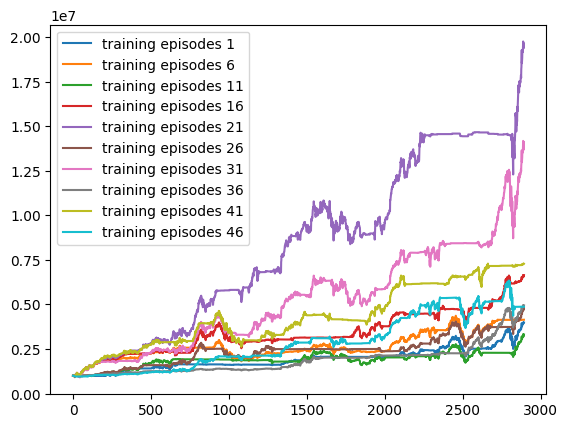

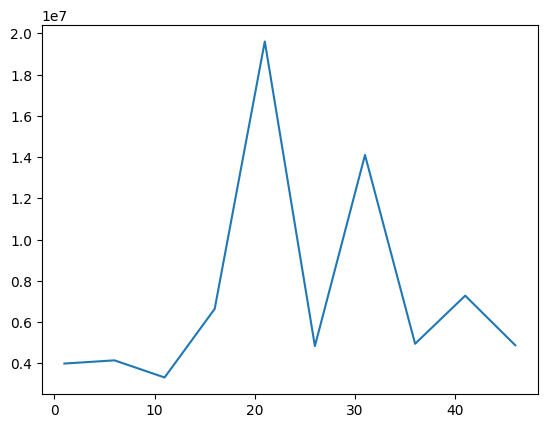

In [26]:
for e, x in zip(episodes_for_training, end_of_training_assets):
    plt.plot(list(range(len(x))), x, label=f"training episodes {e}")
plt.legend()
plt.show()

final_amounts = [mem[-1] for mem in end_of_training_assets]
plt.plot(episodes_for_training, final_amounts)
plt.show()


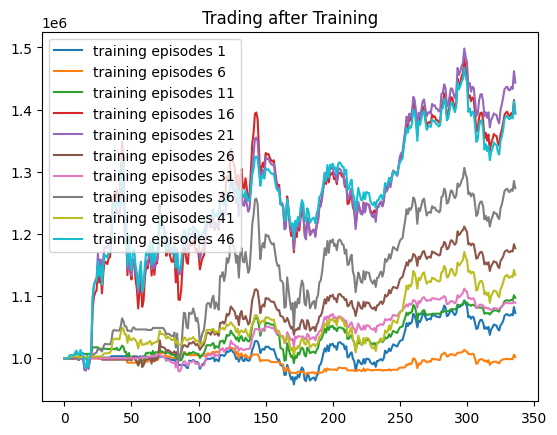

In [37]:
for e, x in zip(episodes_for_training, end_of_trading_assets):
    plt.plot(list(range(len(x))), x, label=f"training episodes {e}")
plt.legend()
plt.title('Trading after Training')
plt.show()

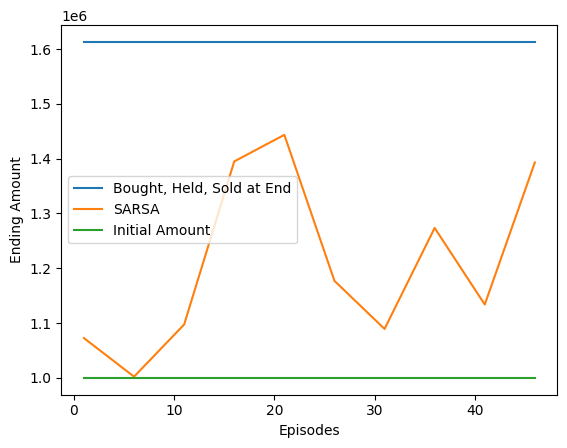

<Axes: >

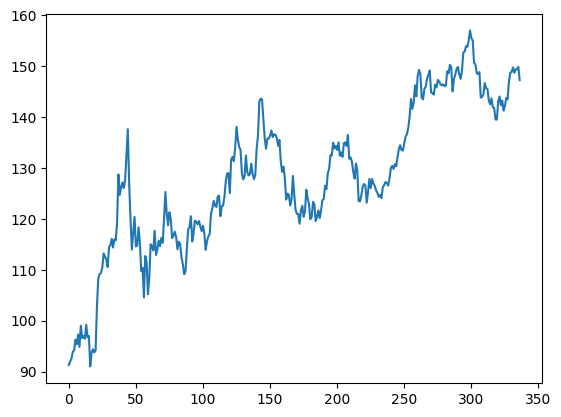

In [56]:
final_amounts = [mem[-1] for mem in end_of_trading_assets]

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(episodes_for_training, [end_amount_if_bought_and_held] * len(episodes_for_training), label='Bought, Held, Sold at End')
plt.plot(episodes_for_training, final_amounts, label='SARSA')
plt.plot(episodes_for_training, [1_000_000] * len(episodes_for_training), label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()
trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].plot()